In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
DATA_PATH = "/content/drive/MyDrive/AudioPatternRecognition/Final_Project/Data.json"

def load_data(data_path):
    """Loads training dataset from json file.

        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists (Dictionary Data in the JSON file) to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

In [ ]:
def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.

    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split

    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split => (from sklearn.model_selection import train_test_split)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis (extra dimention) to input sets (CNN expects 3 dimention data suvh as (130,13,1))
    X_train = X_train[..., np.newaxis]  #... => means what ever the X_train is, + new axis => The result would be 4-dimention: (NumberOfSamples,130,13,1)
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [ ]:
def build_model(input_shape):   #By (import tensorflow.keras as keras) => the input_shape is the 3-dimentions of training set
    """Generates CNN model

    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    # Input layer: a visual representation of a song, where the x-axis represents time, the y-axis represents frequency, and the color intensity represents the amplitude of the frequencies.
    model = keras.Sequential()

    # 1st conv layer
    # analyzing the spectrogram to detect basic patterns, like the rhythm of a drum (for rock) or the smooth flow of a saxophone (for jazz).
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=input_shape))  #32 KERNELS(fILTERS), GRID SIZE (3*3) ==> Also for the first layer we should identify the input shape
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))  # This is like zooming out of the spectrogram to focus on the most important features (e.g., the overall rhythm or dominant frequencies) while ignoring finer details.
    model.add(keras.layers.BatchNormalization())    #Adds a batch normalization layer to normalize the feature maps' activations => Stabilizes and speedup training by reducing internal covariate shift, improving convergence. It also acts as a form of regularization to reduce overfitting.

    # 2nd conv layer => Exactly the same as previous layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer => Filter size and Max pool size is changed.
    model.add(keras.layers.Conv2D(64, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output (which is 2-dimentions) into 1-dimension and feed it into dense layer
    model.add(keras.layers.Flatten()) #Imagine taking all the features you’ve extracted (e.g., rhythms, harmonies, frequencies) and listing them in a single, long list for further analysis.

    #add a dense layer with 64 neurons (fully connected layer for classification) ==> This is like analyzing the list of features to determine which combinations are most important for classifying the music genre (e.g., "rock music often has strong beats and electric guitar riffs").
    model.add(keras.layers.Dense(64, activation='relu'))

    #To solve overfitting: Dropped out probability = 0.2
    model.add(keras.layers.Dropout(0.2))

    # output layer ==> This is the final step where the model predicts the genre of the song (e.g., "80% rock, 10% pop, 10% jazz").
    model.add(keras.layers.Dense(10, activation='softmax')) #As we have 10 genre => we need 10 output neurons each specifies 1 genre

    return model


In [ ]:
def predict(model, X, y):
    """Predict a single sample using the trained model

    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1) => we insert new axis in the begining of the array.

    # perform prediction => a 2 dimantional array and have 10 different values as scores for our 10 different genres: [[0.1, 0.2, ...]] ==> we should extract the index with the max value.
    prediction = model.predict(X)   # X -> (1,130,13,1) => the forst dimention (1) is the number of samples we want to predict (usually usefull in batch prediction)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1) # argmax => extract the index with the max value => [4]

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

In [ ]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [ ]:
def evaluate_model(model, X_test, y_test):
    """Evaluates the model using a Confusion Matrix, Accuracy, Precision, and Recall.

    :param model: Trained CNN model
    :param X_test: Test dataset features
    :param y_test: True labels for the test dataset
    """

    # Get model predictions
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)  # Convert softmax probabilities to class labels

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred_labels)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report (includes Precision, Recall, F1-score, and Accuracy)
    # Precision = TP / (TP + FP)
    # Recall = TP / (TP + FN)
    # Accuracy = (TP + TN) / (Total Samples)

    print("Classification Report:")
    print(classification_report(y_test, y_pred_labels, digits=4))


In [ ]:
def evaluate_model(model, X_test, y_test):
    """Evaluates the model using a Confusion Matrix, Accuracy, Precision, and Recall.

    :param model: Trained CNN model
    :param X_test: Test dataset features
    :param y_test: True labels for the test dataset
    """

    # Get model predictions
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)  # Convert softmax probabilities to class labels

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred_labels)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report (includes Precision, Recall, F1-score, and Accuracy)
    print("Classification Report:")
    print(classification_report(y_test, y_pred_labels, digits=4))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 128, 11, 128)        │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 6, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 6, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 62, 4, 64)           │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 31, 2, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 31, 2, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 30, 1, 64)           │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 15, 1, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 15, 1, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 960)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          61,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 154,698 (604.29 KB)

 Trainable params: 154,186 (602.29 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 56s 277ms/step - accuracy: 0.2565 - loss: 2.3280 - val_accuracy: 0.3899 - val_loss: 1.6653
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 79s 259ms/step - accuracy: 0.4747 - loss: 1.5099 - val_accuracy: 0.5060 - val_loss: 1.3641
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 259ms/step - accuracy: 0.5417 - loss: 1.3000 - val_accuracy: 0.5654 - val_loss: 1.2138
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 86s 280ms/step - accuracy: 0.5848 - loss: 1.1514 - val_accuracy: 0.6001 - val_loss: 1.1388
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 77s 255ms/step - accuracy: 0.6323 - loss: 1.0285 - val_accuracy: 0.6188 - val_loss: 1.0931
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 257ms/step - accuracy: 0.6559 - loss: 0.9737 - val_accuracy: 0.6148 - val_loss: 1.0730
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 49s 258ms/step - accuracy: 0.6722 - loss: 0.9254 - val_accuracy: 0.6509 - val_loss: 0.9861
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 85s 272ms/step - accuracy: 0.7276 - loss: 0

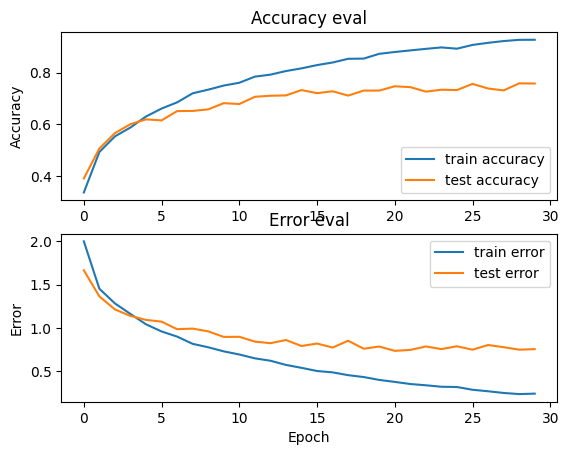

79/79 - 3s - 43ms/step - accuracy: 0.7709 - loss: 0.7013

Test accuracy: 0.7709251046180725
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step


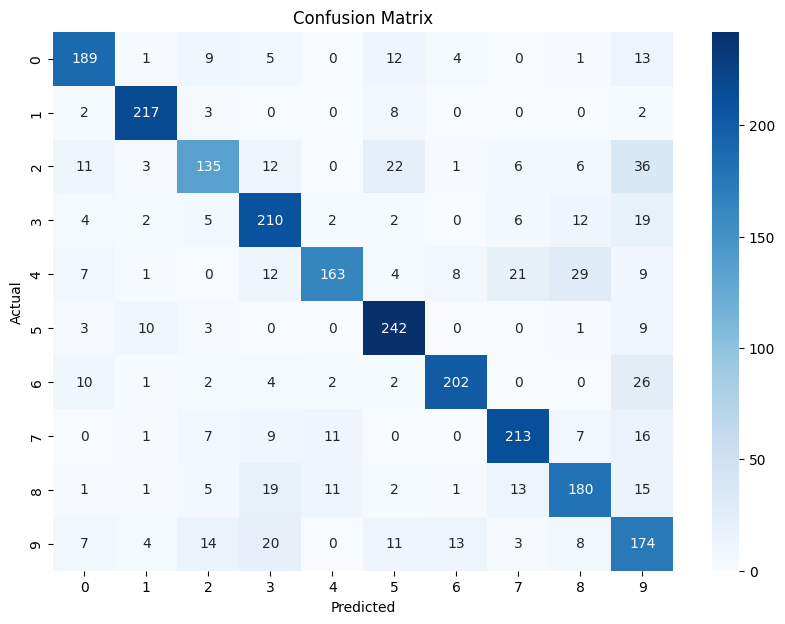

Classification Report:
              precision    recall  f1-score   support

           0     0.8077    0.8077    0.8077       234
           1     0.9004    0.9353    0.9175       232
           2     0.7377    0.5819    0.6506       232
           3     0.7216    0.8015    0.7595       262
           4     0.8624    0.6417    0.7359       254
           5     0.7934    0.9030    0.8447       268
           6     0.8821    0.8112    0.8452       249
           7     0.8130    0.8068    0.8099       264
           8     0.7377    0.7258    0.7317       248
           9     0.5455    0.6850    0.6073       254

    accuracy                         0.7709      2497
   macro avg     0.7802    0.7700    0.7710      2497
weighted avg     0.7792    0.7709    0.7710      2497

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Target: 1, Predicted label: [1]


In [ ]:
if __name__ == "__main__":

    #1. get train, validation, test splits => (Train the model with train dataset, use validation dataset for model optimization, test the model with test dataset which model hasnt seen befor)
    # 0.25: This is the fraction of the dataset to be allocated for testing. For example, if the dataset contains 1,000 samples, 25% (250 samples) will be used as the test set.
    # 0.2: This is the fraction of the remaining data (after splitting off the test set) to be allocated for validation. For example, if 750 samples remain after the test split, 20% (150 samples) will be used as the validation set.
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    #2. create network (CNN Model)
    input_shape = (X_train.shape[1], X_train.shape[2], 1)   #As explaines in the "prepare_datasets" function, the X_train data set are 4-dimentional which weneed the 3 dimentions
    model = build_model(input_shape)

    #3. compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    #4. train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

    # plot accuracy/error for training and validation
    plot_history(history)

    #5. evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # pick a sample to predict from the test set
    X_to_predict = X_test[100]
    y_to_predict = y_test[100]

    # Call the evaluation function
    evaluate_model(model, X_test, y_test)

    #6. predict sample
    predict(model, X_to_predict, y_to_predict)


In [ ]:
# Keras H5 format
model.save("model.h5")